# Improving the VAE implementation in Julia/Flux

In [366]:
using Flux, Flux.Data.MNIST
using Flux: throttle, params, @epochs
using Flux.Tracker: @grad
using Juno: @progress
using LinearAlgebra: dot
using Formatting: sprintf1
using Random

### Architectural Modifications
* Focussing on 2D latent space for visualisation -- much easier to see how well this is working: very hard to understand the failure modes in a 5D space.
* Switched out `tanh` nonlinearities for `relu`. Primarily for efficiency, and to benchmark against PyTorch VAE which is mature and fast. PyTorch takes < 10s per epoch, and VAE in model zoo took approx. 90s per epoch (i7 quad core iMac -- no GPU).
* Moved away from Binarised MNIST to floating point MNIST data. This has a huge impact on performance. The data as Float64 can take advantage of BLAS kernels, which the Boolean version cannot, and this coupled with type conversions happening implicitly along the chain, cause substantial performance issues. One imagines that better Bool kernels in the future will permit the intuitively better performance that could be achieved with Binary data.
* Reduced the decoder regularization a little. The network seemed to struggle slightly more to find good parameterisations with square norm penalisation of $10^{-2}$. (Although I may have just got unlucky.)
* Switched up the initialisation slightly, per the relu initialisation discussed in He Kaiming's paper. This increases the variance of the random uniform and adds some noise to the bias. This also mirrors PyTorch. I have typically observed better optima, although some of the peripheral samples from the prior look over-saturated.
* Shuffled the training data before partitioning into batches.
* <span style="color:red"><b>future work: create a Float32 version taking advantage of BLAS operations on lower precision</span></b>. PyTorch and Tensorflow can both benefit from this, and I suspect this modification will get us close to the speed of the PyTorch implementation. We currently get a DualNumber conversion bug; stacktrace:

Stacktrace:<br>
 [1] convert(::Type{Float32}, ::ForwardDiff.Dual{Nothing,Float64,1}) at ./number.jl:7<br>
 [2] partial(::typeof(convert), ::Float64, ::Int64, ::Type, ::Float64) at .../.julia/packages/Flux/jbpWo/src/tracker/array.jl:346 <br> 
 [3] _broadcast_getindex at ./broadcast.jl:574 [inlined] <br>
 ...

### Coding style modifications
* Using more human friendly variable names. It took me a while to get used to the `f` and `g` in the model zoo, and while compact, they are non-standard and unhelpful to new users.
* More friendly function names, and long form function definitions. This allows better naming conventions and comments. Also useful for debugging and timing.
* Not a fan of the `@throttle` loss function updates: I'm more interested in understanding the performance after a fixed number of iterations than a fixed wallclock time. Switched this to every 100 iters.

### Implementation modifications
* The KL divergence had a small error in it: had `(logσ)^2` rather than `log(σ^2)`. This was fixed but...
* Anecdotally parameterising the variance rather than the stdev seems to result in better optima (or at least faster ascent to an optima). Therefore the KL has been changed anyway. This maybe because the optimisation has a 'bias' towards lower variance posteriors (not an actual bias, but has to work harder for larger variances). Intuitively this seems a better choice since the KL behaves assymetrically to these cases: will result in a very heavy penalisation if the optimisation over-shoots on variance and could lead to oscillation issues. There's a very small performance benefit in the other way, but I think this to be insignificant.
* The gradient of the log reconstruction can be calculated more efficiently by putting in a custom function in (binary cross entropy -- which is what the bernoulli likelihood is). A similar design choice has been made in Tensorflow and PyTorch. I've coded up a gradient for this which is plugged into Flux (`BCE`). This has led to substantial performance gains too.
* Sampled from the posterior (via the reparameterized normal) using explicit instantiation of a $M \times D$ random matrix. This previously used a broadcasted elementwise operation. <span style="color:blue"><b>This is critical for the performance of the VAE</b></span>. The broadcast version actually instantiates a different random variable on the forward pass to the backward pass, and adds additional noise into the objective. This causes the optimisation to follow a different objective function with an implicitly higher noise prior. This is to do with the guts of how Flux handles the tape which I don't understand yet. This was a pernicious bug in the previous implementation.
* [A number of other helper functions have been made which I'll detail later...]

------------------------
#### Define some useful functions before the model

In [349]:
# Custom Gradient Function: Binary Cross Entropy
function BCE(X, P)
    @assert size(X) == size(P)
    bce = 0.0
    bce_fn(x, p) = dot(x, log.(p .+ eps())) + dot(1 .- x, log.(1 .- p .+ eps()))
    @views for i in 1:size(X,2)
        bce -= bce_fn(X[:,i], P[:,i])
    end
    return bce
end

BCE(X::TrackedArray, P::TrackedArray) = Tracker.track(BCE, X, P)
BCE(X::AbstractArray, P::TrackedArray) = Tracker.track(BCE, X, P)
BCE(X::TrackedArray, P::AbstractArray) = Tracker.track(BCE, X, P)

∇P_BCE(X, P) = - (X - P) ./ ((P .+ eps()) .* (1 .- P .+ eps()))
∇X_BCE(P) =  - (log.(P .+ eps()) - log.(1 .- P .+ eps()))

@grad function BCE(X, P)
    return BCE(Tracker.data(X), Tracker.data(P)), Δ -> (Δ * ∇X_BCE(P), Δ * ∇P_BCE(X, P))
end

binary_cross_entropy = BCE   # (alias)

BCE (generic function with 4 methods)

In [350]:
function zero_grad!(ps)
    for p in ps
        p.tracker.grad .= 0
    end
end

zero_grad! (generic function with 1 method)

In [258]:
# Define new RELU initialisation
function init_2d_relu_kaiming_uniform(n_in, n_out)
    bnd = sqrt(3.0 * 2.0 / n_in)
    W = (rand(n_out, n_in) .- 0.5) .* (2. * bnd)
    b = (rand(n_out) .- 0.5) .* (2. / sqrt(n_in))
    return W, b
end

function Dense_relu(in::Integer, out::Integer)
    W, b = init_2d_relu_kaiming_uniform(in, out)
    return Dense(param(W), param(b), relu)
end

Dense_relu (generic function with 2 methods)

-------------------------------
### Define and run the model

In [319]:
########## Load data and partition into mini batches of size M ############
X = float.(hcat(vec.(MNIST.images())...)) #.> 0.5  # ==> no benefit in binarising
N, M = size(X, 2), 100
shf = randperm(N)
data = [convert.(Float64, X[:,shf[i]]) for i in Iterators.partition(1:N,M)];

In [320]:
############## Instantiate Parameters and Networks #######################
# Latent dimensionality, # hidden units.
Dz, Dh = 2, 400;

A, μ, logsigma = Dense_relu(28^2, Dh), Dense(Dh, Dz), Dense(Dh, Dz)
encoder(X) = (h = A(X); (μ(h), logsigma(h)))
decoder = Chain(Dense_relu(Dz, Dh), Dense(Dh, 28^2, σ));

In [377]:
################################# Define Model ###########################
# Generative Model / Variational Posterior / Loss Function
#
# Anecdotally parameterising the variance rather than the stdev seems to result
# in better optima (or at least faster ascent to optima), but easy to switch
# to a stdev parameterisation.

function kl_q_p(μ, logvar)
    return -0.5 * sum(- exp.(logvar) - μ.^2 .+ 1 .+ logvar)
end

function ELBO_MC(X)
    # variational posterior
    (μ_post, logvar_post) = encoder(X)
    
    # (single particle) MC approx. of posterior
    rz = μ_post .+ exp.(0.5 .* logvar_post) .* randn(size(μ_post))
    
    # estimate of log reconstruction term
    log_recon = -BCE(X, decoder(rz))
    
    # KL Divergence to N(0,I) Prior (assumes diagonal posterior cov.)
    kl  = kl_q_p(μ_post, logvar_post)
    
    return (log_recon - kl)/M
end

function loss(X)
    loss = -ELBO_MC(X)
    reg = 1e-4 * sum(x->sum(x .* x), params(decoder))
    reg = 0.
    return loss + reg
end

opt = ADAM(params(A, μ, logsigma, decoder), 0.001);

In [322]:
epochs = 10

@time @epochs epochs for (i, d) in enumerate(zip(data))
    l = loss(d...)
    (i % 100 == 0) && println("Batch iter ", i, " loss: ", sprintf1("%.3f", l.data))
    Tracker.back!(l)
    opt()
end

┌ Info: Epoch 1
└ @ Main /Users/abird/.julia/packages/Flux/jbpWo/src/optimise/train.jl:93


Batch iter 100 loss: 196.084
Batch iter 200 loss: 176.534
Batch iter 300 loss: 174.542
Batch iter 400 loss: 175.432
Batch iter 500 loss: 171.995
Batch iter 600 loss: 164.275


┌ Info: Epoch 2
└ @ Main /Users/abird/.julia/packages/Flux/jbpWo/src/optimise/train.jl:93


Batch iter 100 loss: 170.918
Batch iter 200 loss: 159.556
Batch iter 300 loss: 165.666
Batch iter 400 loss: 166.314
Batch iter 500 loss: 164.879
Batch iter 600 loss: 157.177


┌ Info: Epoch 3
└ @ Main /Users/abird/.julia/packages/Flux/jbpWo/src/optimise/train.jl:93


Batch iter 100 loss: 165.207
Batch iter 200 loss: 154.310
Batch iter 300 loss: 161.721
Batch iter 400 loss: 163.570
Batch iter 500 loss: 162.108
Batch iter 600 loss: 153.803


┌ Info: Epoch 4
└ @ Main /Users/abird/.julia/packages/Flux/jbpWo/src/optimise/train.jl:93


Batch iter 100 loss: 161.538
Batch iter 200 loss: 151.404
Batch iter 300 loss: 159.055
Batch iter 400 loss: 162.869
Batch iter 500 loss: 161.360
Batch iter 600 loss: 151.360


┌ Info: Epoch 5
└ @ Main /Users/abird/.julia/packages/Flux/jbpWo/src/optimise/train.jl:93


Batch iter 100 loss: 160.292
Batch iter 200 loss: 150.292
Batch iter 300 loss: 158.149
Batch iter 400 loss: 160.437
Batch iter 500 loss: 159.240
Batch iter 600 loss: 150.359


┌ Info: Epoch 6
└ @ Main /Users/abird/.julia/packages/Flux/jbpWo/src/optimise/train.jl:93


Batch iter 100 loss: 159.673
Batch iter 200 loss: 148.389
Batch iter 300 loss: 156.089
Batch iter 400 loss: 159.979
Batch iter 500 loss: 159.286
Batch iter 600 loss: 149.136


┌ Info: Epoch 7
└ @ Main /Users/abird/.julia/packages/Flux/jbpWo/src/optimise/train.jl:93


Batch iter 100 loss: 158.412
Batch iter 200 loss: 147.156
Batch iter 300 loss: 155.440
Batch iter 400 loss: 158.990
Batch iter 500 loss: 157.822
Batch iter 600 loss: 147.802


┌ Info: Epoch 8
└ @ Main /Users/abird/.julia/packages/Flux/jbpWo/src/optimise/train.jl:93


Batch iter 100 loss: 157.180
Batch iter 200 loss: 146.616
Batch iter 300 loss: 154.630
Batch iter 400 loss: 157.858
Batch iter 500 loss: 157.193
Batch iter 600 loss: 147.618


┌ Info: Epoch 9
└ @ Main /Users/abird/.julia/packages/Flux/jbpWo/src/optimise/train.jl:93


Batch iter 100 loss: 156.870
Batch iter 200 loss: 145.784
Batch iter 300 loss: 153.604
Batch iter 400 loss: 157.103
Batch iter 500 loss: 156.789
Batch iter 600 loss: 147.029


┌ Info: Epoch 10
└ @ Main /Users/abird/.julia/packages/Flux/jbpWo/src/optimise/train.jl:93


Batch iter 100 loss: 156.596
Batch iter 200 loss: 144.938
Batch iter 300 loss: 153.650
Batch iter 400 loss: 155.908
Batch iter 500 loss: 156.401
Batch iter 600 loss: 145.870
187.381568 seconds (2.37 G allocations: 164.558 GiB, 15.82% gc time)


## Evaluation Tools

In [378]:
# Remove tracker from all parameters to avoid constructing computational graph
function create_eval_mode_model(A, μ, logsigma, decoder)
    decoder_nog = mapleaves(Tracker.data, decoder)
    A_nog = mapleaves(Tracker.data, A)
    μ_nog = mapleaves(Tracker.data, μ)
    logsigma_nog = mapleaves(Tracker.data, logsigma)
    enc_nog(X) = (h = A_nog(X); (μ_nog(h), logsigma_nog(h)))

    function ELBO_MC2_dbg(X; stochastic=false)
        (mu_post, logsigma_post) = enc_nog(X)
        
        if !stochastic
            rz = mu_post
        else 
            rz = mu_post .+ exp.(0.5 .* logsigma_post) .* randn(size(mu_post))
        end
        
        log_recon = -BCE(X, decoder_nog(rz))
        kl  = kl_q_p2(mu_post, logsigma_post)

        return (log_recon - kl)/M
    end


    function loss2_dbg(X; stochastic=false)
        loss = -ELBO_MC2_dbg(X; stochastic=stochastic)
        reg = 1e-3 * sum(x->sum(x.W .* x.W) + sum(x.b .* x.b), 
            [decoder_nog.layers[1], decoder_nog.layers[2]])
        return loss
    end

    return loss2_dbg
end;

In [374]:
# Create evaluation "Flux-free" version of model
loss_nog = create_eval_mode_model(A, μ, logsigma, decoder)

########## Load test data and partition into mini batches of size M ############
Xtest = float.(hcat(vec.(MNIST.images(:test))...))
Ntest = size(Xtest, 2)
data_test = [convert.(Float64, Xtest[:,i]) for i in Iterators.partition(1:Ntest,M)];

In [376]:
println("Training Loss: ", sprintf1("%.3f", sum([loss_nog(data[i]) for i in 1:600])/600))
println("Test Loss: ", sprintf1("%.3f", sum([loss_nog(data_test[i]) for i in 1:100])/100))

Training Loss: 150.444
Test Loss: 151.709


### Plot 2D latent manifold
See below for function definition.

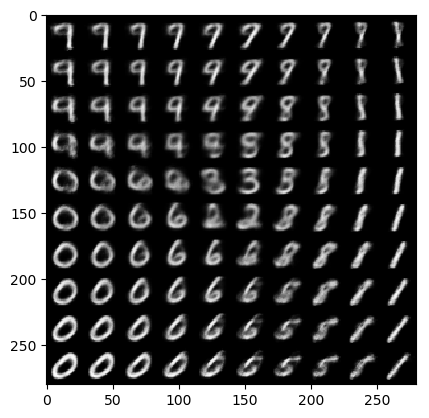

PyObject <matplotlib.image.AxesImage object at 0xa497f8860>

In [365]:
plot_2dtile_imshow(decoder, nsmp_dim=10, cmap="binary_r", scale=2)

In [364]:
using PyPlot

function _gen_cube_grid(vmin, vmax; nsmp_dim=8, ndim=2, force=false)
    """
    Generate coordinates for equally spaced meshgrid in `ndim` dimensions.
    The output is in 'long' rather than 'wide' form: i.e. if `ndim=2`,
    an n x 2 matrix is returned.
    """
    (!force) && nsmp_dim^ndim > 1e4 && throw("More than 10,000 points requested.")
    xs = collect(range(vmin, stop=vmax, length=nsmp_dim))
    xs = hcat(repeat(xs, outer=(nsmp_dim,1)), repeat(xs, inner=(nsmp_dim,1)))
    return xs
end


function _tile_image_grid(Ms; gridsz=nothing)
    
    num = length(Ms)
    # primarily to catch user fails of passing in a single array
    @assert num <= 256 "too many images. Expecting at most 256."
    @assert ndims(Ms[1]) == 2 "each element of Ms should be a 2 dimensional image array"
    @assert maximum(size(Ms[1]))*sqrt(float(num)) <= 4000 "resulting image array is too large. Reduce number of Ms."
    @assert length(unique([size(Ms[i]) for i in 1:num])) == 1 "all arrays in Ms should be same size."
    
    Ms_sz = size(Ms[1])
    
    if gridsz == nothing
        poss = [[x,Int(ceil(num/x))] for x in range(1,stop=Int(floor(sqrt(num)))+1)]
        resultsz = [x .* Ms_sz for x in poss]
        choice = findmin([sum(x) for x in resultsz])[2]
        gridsz = sort(poss[choice])
    else
        gridsz = collect(gridsz)
    end
    @assert isa(gridsz, Array{Int, 1}) && size(gridsz) == (2,)
    
    gridsz = (gridsz == nothing) ? subplot_gridsize(num) : gridsz

    
    out = zeros((gridsz .* Ms_sz)...)
    for ii in 1:gridsz[1], jj in 1:gridsz[2]
        i = (ii-1) * gridsz[2] + jj
        ix_xs = ((ii-1)*Ms_sz[1] + 1) : (ii*Ms_sz[1])
        ix_ys = ((jj-1)*Ms_sz[2] + 1) : (jj*Ms_sz[2])
        out[ix_xs, ix_ys] = copy(Ms[i])   # not sure if the copy is necessary. Freq is for PyPlot.
    end
    return out
end

function plot_2dtile_imshow(forward_network; nsmp_dim=8, scale=2, im_shp=(28,28), transpose=false, cmap="viridis")
    """
    :param forward_network: decoder for VAE. Should accept 2 x n matrices.
    :param nsmp_dim: number of (equally spaced) samples in both x and y dims.
    :param scale: scale of grid on latent space (will be [-scale, scale] in both dims)
    :param im_shp: size/shape of each image. Default = (28,28) for MNIST.
    :param transpose: images need transposing before displaying (e.g. if in row major format)
    :param cmap: colormap -- default "viridis", suggest also "binary_r" for greyscale.
    """
    zs = _gen_cube_grid(-scale, scale, nsmp_dim=nsmp_dim)
    tr = (transpose == true ? Base.transpose : x -> x)
    ims = [reshape(forward_network(zs[ii,:]).data, im_shp) for ii in 1:size(zs,1)]
    imtiled = tr(_tile_image_grid(ims))
    ax = PyPlot.plt[:imshow](imtiled, cmap=cmap)
end

plot_2dtile_imshow (generic function with 1 method)